In [15]:
import os
import cv2
import numpy as np
import glob
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Reading the Data

In [2]:
# importing the tram_csv
tram_df = pd.read_csv('tram_filenames.csv')
tram_df.drop(columns=tram_df.columns[0], axis=1, inplace=True)
tram_jpg = np.array(tram_df.filename_jpg)
tram_jpg

array(['rs02096.jpg', 'rs07844.jpg', 'rs06555.jpg', ..., 'rs08401.jpg',
       'rs06969.jpg', 'rs05051.jpg'], dtype=object)

In [3]:
len(tram_df.filename_mask.unique())

1318

In [17]:
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Daten/rs19_val/uint8/rs19_val/'
path_images = '/Users/arasdirekoglu/Documents/Daten/rs19_val/jpgs/rs19_val/' 

# Setting up a breaker for test run 
#breaker = 0

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop 
for filename in os.listdir(path_images):
    if filename.endswith('.jpg') and filename in tram_jpg:
        image = Image.open(path_images+filename)
        image = image.filter(ImageFilter.MedianFilter(size= 3))
        image = np.array(image.resize((512, 256),Image.NEAREST))
        mask = Image.open(path_masks+filename[:7]+'.png')
        mask = mask.filter(ImageFilter.MedianFilter(size= 3))
        mask = np.array(mask.resize((512,256),Image.NEAREST))
        mask = np.expand_dims(mask, axis=2)
        for layer in range(len(mask[0,0,:])):
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
        image_dataset.append(image)
        mask_dataset.append(mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

/var/folders/bs/l4fdfr9d7td91bdr2lf6yx640000gn/T/ipykernel_38698/3707713172.py:20: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = np.array(image.resize((512, 256),Image.NEAREST))
/var/folders/bs/l4fdfr9d7td91bdr2lf6yx640000gn/T/ipykernel_38698/3707713172.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = np.array(mask.resize((512,256),Image.NEAREST))


image:  (1318, 256, 512, 3)
mask:  (1318, 256, 512)
image:  (1318, 256, 512, 3)
mask:  (1318, 256, 512, 1)
unique labels in mask [0 1]


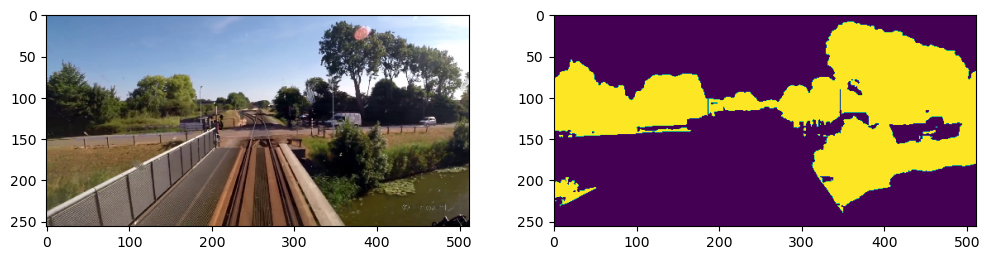

In [25]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()


# Split of Data

In [26]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [27]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [28]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [29]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=25,
                        epochs=10,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/10
43/43 [==============================] - 705s 16s/step - loss: 0.2454 - iou_score: 0.6109 - f1-score: 0.7473 - accuracy: 0.9166 - val_loss: 2.2762 - val_iou_score: 0.3189 - val_f1-score: 0.4820 - val_accuracy: 0.8763
Epoch 2/10
43/43 [==============================] - 724s 17s/step - loss: 0.1394 - iou_score: 0.7211 - f1-score: 0.8374 - accuracy: 0.9478 - val_loss: 0.4510 - val_iou_score: 0.4442 - val_f1-score: 0.6135 - val_accuracy: 0.8989
Epoch 3/10
43/43 [==============================] - 705s 16s/step - loss: 0.1238 - iou_score: 0.7419 - f1-score: 0.8515 - accuracy: 0.9520 - val_loss: 0.1893 - val_iou_score: 0.6549 - val_f1-score: 0.7907 - val_accuracy: 0.9352
Epoch 4/10
43/43 [==============================] - 710s 17s/step - loss: 0.1115 - iou_score: 0.7597 - f1-score: 0.8627 - accuracy: 0.9565 - val_loss: 0.2712 - val_iou_score: 0.6233 - val_f1-score: 0.7670 - val_accuracy: 0.9047
Epoch 5/10
43/43 [==============================] - 704s 16s/step - loss: 0.1063 - iou_s

In [221]:
# function for triangle roi
def roi_triangle(predicted_img):
    width = predicted_img.shape[1]
    height = predicted_img.shape[0]
    roi = [
        (0, height),
        (width / 2, height / 2 ),
        (width, height)
    ]
    roi = np.array([roi], np.int32)
    predicted_img = np.ascontiguousarray(predicted_img, dtype=np.uint8)
    mask = np.zeros_like(predicted_img)
    #channel_count = 2
    match_mask_color = 255
    cv2.fillPoly(mask, (np.array([roi], np.int32)), match_mask_color)
    predicted_img = cv2.bitwise_and(predicted_img, mask)
    
    return predicted_img

1/1 [==============================] - 0s 206ms/step


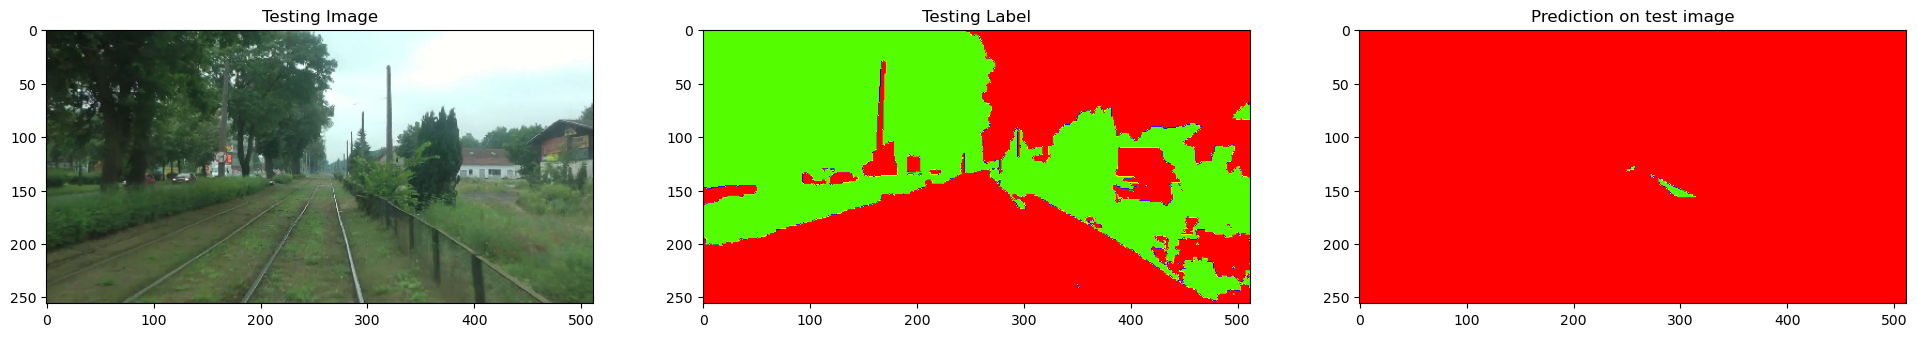

In [222]:
#test_img_number = np.random.randint(0, len(X_test))
test_img_number = 6
test_img = X_test[test_img_number]
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)#this is to make (256, 512, 1) -> (1, 256, 512, 1)
#test_img_input[:int(256/2),:,layer]=0
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis


#predicted_img[:int(256/2),:,layer]=0 # Use for half image 
predicted_img = roi_triangle(predicted_img) # Use this for triangle

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [32]:
# 6, 13, 228, rs230

/var/folders/bs/l4fdfr9d7td91bdr2lf6yx640000gn/T/ipykernel_38698/2392840418.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  rsimage = np.array(rsimage.resize((512, 256), Image.NEAREST))
/var/folders/bs/l4fdfr9d7td91bdr2lf6yx640000gn/T/ipykernel_38698/2392840418.py:8: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  rs_ground = np.array(rs_ground.resize((512, 256),Image.NEAREST))


1/1 [==============================] - 0s 432ms/step


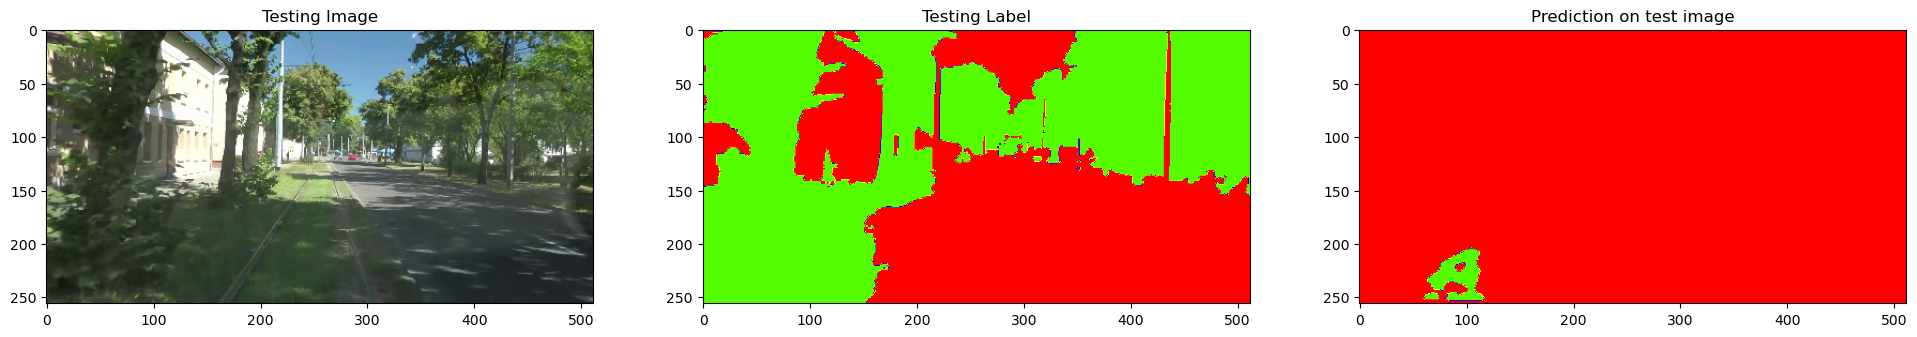

In [188]:
rsimage = Image.open(path_images+'rs00230.jpg')
rsimage = rsimage.filter(ImageFilter.MedianFilter(size=3))
rsimage = np.array(rsimage.resize((512, 256), Image.NEAREST))
rsimage_input=np.expand_dims(rsimage, 0)

rs_ground = Image.open(path_masks+'rs00230.png')
rs_ground = rs_ground.filter(ImageFilter.MedianFilter(size= 3))
rs_ground = np.array(rs_ground.resize((512, 256),Image.NEAREST))
rs_ground = np.expand_dims(rs_ground, axis=2)
for layer in range(len(rs_ground[0,0,:])):
    rs_ground[:,:,layer][rs_ground[:,:,layer]!=label_of_interest]=0
    rs_ground[:,:,layer][rs_ground[:,:,layer]==label_of_interest]=1

prediction = (model.predict(rsimage_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

#predicted_img[:int(256/2),:,layer]=0 # Use this for half image 
predicted_img = roi_triangle(predicted_img) # Use this for triangle

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(rsimage_input[0,:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(rs_ground[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [177]:
# Percentage Veg half image 
whole_roi = (predicted_img.shape[0] * predicted_img.shape[1])/2
veg = np.count_nonzero(predicted_img == 1)
veg_precent = (veg/whole_roi)*100
print(veg_precent)

2.29949951171875


In [201]:
# Percentage Veg roi triangle 
whole_roi = ((predicted_img.shape[0] * predicted_img.shape[1])/2)/2
veg = np.count_nonzero(predicted_img == 1)
veg_precent = (veg/whole_roi)*100
print(veg_precent)

0.6744384765625
